# **Advanced Lane Finding** 
February 1, 2020 - John Robinson

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

**Project 2** in Udacity’s Self-Driving Car Nanodegree

My Project Repository: https://github.com/johnrobinsn/CarND-Advanced-Lane-Lines

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Project Rubric: https://review.udacity.com/#!/rubrics/1966/view
    
My Project Writeup: https://github.com/johnrobinsn/CarND-Advanced-Lane-Lines

More about the nanodegree program: https://www.udacity.com/drive


## Import Packages

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import os
import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Helper Functions

Below are some helper functions.

In [2]:
def hls_colorspace(img):
    cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)                

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
def show_image_grid(images, stage="final"):
    f, ax = plt.subplots(len(images),3,sharex=True,sharey=True,figsize=(15,45))

    for i in range(len(images)):
        image = plt.imread(image_dir+images[i])
        ax[i,1].axis("off")
        ax[i,2].axis("off")
        ax[i,0].set_ylabel(os.path.splitext(os.path.basename(images[i]))[0])
        ax[i,0].set(frame_on=False)
        ax[i,0].imshow(image)
        ax[i,1].imshow(show_lines(image, stage=stage))
        ax[i,2].imshow(show_lines(image))
    f.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
# Utility function to extract frames from a video and look for lane lines
# First column is the original frame, second column is an interstitial frame
# third column is the final image with lane markers

def show_video_grid(video, start = 0, stop = 10, stage="final"):
    
    video = VideoFileClip(video)
    
    duration = video.duration
    start = max(min(duration, start),0)
    stop = max(min(duration, stop), 0)
    num = stop-start+1
    
    f, ax = plt.subplots(num,3,sharex=True,sharey=True,figsize=(15,45))

    for i in range(start,stop+1):
        image = video.get_frame(i)
        ax[i,1].axis("off")
        ax[i,2].axis("off")
        ax[i,0].set_ylabel(str(i)+"s")
        ax[i,0].set(frame_on=False)
        ax[i,0].imshow(image)
        ax[i,1].imshow(show_lines(image, stage=stage))
        ax[i,2].imshow(show_lines(image))

    f.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Camera Calibration
Lenses on cameras can introduce image abberations especially near the edges of the lenses.  Some of the more common image distortions that can be observed are "bowing" or "pin-cushion" effects.  Using some numerical analysis and a set of reference images, we can correct for some of these distortions.  We can use a series of "chessboard" images taken with the same camera/lens combination.  Assuming these images are of the same chessboard with the same known numberr of interior corners we can calculate a transformation matrix and a set of distortion coefficients that can be used to correct future images.

Here is an example of a chessboard image with 9x6 interior corners.

<img src="camera_cal/calibration3.jpg" alttext="Chessboard Examples" width="300" />

A utility function follows that takes a "wild-card" path to a collection of such chessboard images and the number of interior corners in the x and y directions and returns the matrix and distortion coefficients.

In [5]:
# Calibrate Camera Using a Collection of Chessboard Images
# Assumptions:
# All chessboard images have been taken with the same camera
# All chessboard images have the same dimensions (w x h)
# All squares on the chessboards are visible in the images
# All chessboard images have the same number of interior corners (ie intersections of black and white squares)
#
# globPattern: path and wildcard pattern to chessboard images
# nx the number of interior corners present in the chessboards in the x dimension
# ny the number of interior corners present in the chessboards in the y dimension
#
# 
def calibrateCameraFromImages(globPattern, nx, ny):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(globPattern)
    imgsize = None

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgsize = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)
    
    return mtx, dist

Calculate the matrix and distortion coefficients for the images provided.

In [6]:
mtx, dist = calibrateCameraFromImages("camera_cal/calibration*.jpg", 9, 6)

## Correct the image distortion using the matrix and distortion coefficients
Using the calculated matrix and distortion coefficents we demonstrate the ability to uses this information to correct the distortion in the same chessboard images.

In [7]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print("here")
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    else:
        print("no corners found")

    # Return the resulting image and matrix
    return warped, M

Show an example of using the matrix and distortion coefficients to unwarp one of the chessboard images.

camera_cal/calibration9.jpg


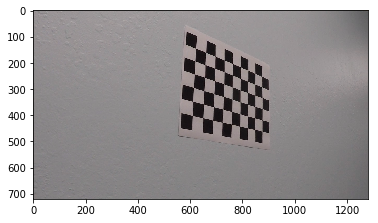

here


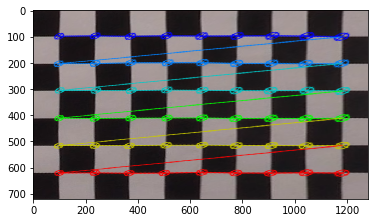

In [8]:
# Make a list of calibration images
images = glob.glob("camera_cal/calibration9.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    print(fname)
    img = cv2.imread(fname)
    plt.imshow(img)
    plt.show()
    warped, M = corners_unwarp(img, 9, 6, mtx, dist)
    plt.imshow(warped)
    plt.show()

## Show an example image being corrected using the matrix and distortion coefficients
You can see the the "pincushioning" shown in the before image has been largely correcte and that the lines appear much straighter.

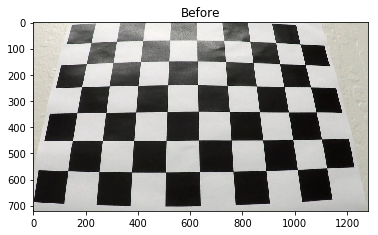

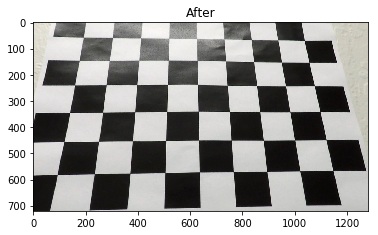

In [9]:
img = mpimg.imread("camera_cal/calibration3.jpg")
plt.imshow(img)
plt.title("Before")
plt.show()
plt.imshow(cv2.undistort(img, mtx, dist, None, mtx))
plt.title("After")
plt.show()

## Color Filters


In [10]:
def filter_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    vi = np.zeros_like(v)
    vi[(v > 150) & (s > 70)] = 1
    return vi

In [11]:
 def hls_select(img):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    yellow_lower = np.array([10, np.round(0.3 * 255), np.round(0.38 * 255)])
    yellow_upper = np.array([30, np.round(0.9 * 255), np.round(1.00 * 255)])

    # Use inRange to generate a mask that identifies all yellow pixels
    yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)
    
    l = hls[:,:,1]
    s = hls[:,:,2]
    s_filtered = np.zeros_like(s)
    s_filtered[(s > 170) & (s <= 255)] = 1
    light = np.zeros_like(s)
    light[(l >= 200)] = 1  #working 200
    dark = np.zeros_like(s)
    dark[(l < 64)] = 1 #working 64
    c_filtered = np.zeros_like(s)
    c_filtered[(((s_filtered==1) & (dark!=1)) | (light==1) | (yellow_mask > 0))] = 1
    return c_filtered

In [12]:
def sobel_thresh(img, orient='x', thresh=(0, 255)):
    g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(g, cv2.CV_64F, 1, 0))
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(g, cv2.CV_64F, 0, 1))
    scaled = np.uint8(255*sobel/np.max(sobel))
    output = np.zeros_like(scaled)
    output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return output

def hsl_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    output = np.zeros_like(s)
    output[(s >= sthresh[0]) & (s <= sthresh[1])] = 1
    return output

def hsv_threshold(image, vthresh=(0,255)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    output = np.zeros_like(v)
    output[(v >= vthresh[0]) & (v <= vthresh[1])] = 1
    return output

In [13]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzero)
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty #, out_img

In [14]:
def find_lane_pixels_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [15]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [16]:
def radius_of_curvature(curve, y_eval):
    A,B,C = curve
    curverad = np.sqrt(np.power(1+np.square(2*A*y_eval + B),3))/np.absolute(2*A) ## Implement the calculation of the left line here
    return curverad

In [17]:
global left_fits
global right_fits

def clear_line_cache():
    global left_fits
    global right_fits
    left_fits = []
    right_fits = []

def binarize_image(img):
    a = filter_yellow(img)
    b = hls_select(img)
    c = np.zeros_like(a)
    c[(a==1)|(b==1)] = 1
    return c

# Some special case processing for the harder challenge video
# deal with the very washed out images due to sunlight
def binarize_image_hardest(img):
    sobel_x_thresh = (20,255) # sobel x threshold
    sobel_y_thresh = (20,255) # sobel y threshold
    s_thresh = (240,255) # s threshold
    v_thresh = (240,255) # v threshold
    
    output = np.zeros_like(img[:,:,0])
    sobel_x = sobel_thresh(img, orient='x', thresh=sobel_x_thresh) 
    sobel_y = sobel_thresh(img, orient='y', thresh=sobel_y_thresh) 

    st = hsl_threshold(img, sthresh=s_thresh)
    vt = hsv_threshold(img, vthresh=v_thresh)
    output[((sobel_x == 1) & (sobel_y == 1) | ((st == 1) & (vt == 1)) )] = 1
    return output
    
# The hardest flag enables some special case processing for the hard_challenge_video
def show_lines(img, use_line_cache=False, show_diag=False, hardest=False):
    
    def warp(img, src, dst):
        img_size=(img.shape[1],img.shape[0])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)
        return warped

    # correct image for camera distortion
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # binarize the image trying to preserve lane lines as much as possible
    if hardest:
        filtered = binarize_image_hardest(undistorted)
    else:
        filtered = binarize_image(undistorted)
    
    if hardest:
        img_size = (img.shape[1], img.shape[0])
        imshape = img.shape
        midx = int(imshape[1]/2)
        marginx = int(midx*0.30)
        midy = int(imshape[0]/2)
        marginy = int(midy*0.5)
        marginbot = 0
    else:
        # values used for warping from the projected camera view to a birds eye view
        img_size = (img.shape[1], img.shape[0])
        imshape = img.shape
        midx = int(imshape[1]/2)
        marginx = int(midx*0.08)
        midy = int(imshape[0]/2)
        marginy = int(midy*0.25)
        marginbot = 0
    
    
    # values to calcuate shape to clip out the background details
    nimshape = filtered.shape
    nmidx = int(nimshape[1]/2)
    nmarginx = int(nmidx*0.09)
    nmidy = int(nimshape[0]/2)
    nmarginy = int(nmidy*0.25)
    nmarginbot = 45
    
    prewarp = filtered
    
    if not hardest:
        # try to cull out background details by assuming the lane lines exist largely within
        # an isoceles trapezoid
        vertices = np.array([[(0,imshape[0]-nmarginbot),(nmidx-nmarginx, nmidy+nmarginy), (nmidx+nmarginx, nmidy+nmarginy), (nimshape[1],nimshape[0]-nmarginbot)]], dtype=np.int32)
        region = region_of_interest(filtered, vertices )

        prewarp = region
    
    src = np.float32([(180,imshape[0]-marginbot),(midx-marginx, midy+marginy), (midx+marginx, midy+marginy), (imshape[1]-180,imshape[0]-marginbot)])
    dst = np.float32([(300,imshape[0]),(300, 0), (imshape[1]-300, 0), (imshape[1]-300, imshape[0])])   
        
    birds_eye = warp(prewarp, src, dst)

    global left_fits
    global right_fits
    
    if not use_line_cache:
        left_fits = []
        right_fits = []
    
    if len(left_fits) > 0 and len(right_fits) > 0:
        avg_left_fit = np.sum(left_fits,axis=0)/len(left_fits)
        avg_right_fit = np.sum(right_fits, axis=0)/len(right_fits)

        leftx, lefty, rightx, righty = find_lane_pixels_around_poly(birds_eye, avg_left_fit, avg_right_fit)
    else:
        leftx, lefty, rightx, righty = find_lane_pixels(birds_eye)
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    have_left_fit = False
    left_fit = None
    left_fit_meters = None
    if (len(lefty) > 0 and len(leftx) > 0):
        left_fit = np.polyfit(lefty, leftx, 2)
        have_left_fit = True
        left_fit_meters = np.polyfit(lefty * ym_per_pix, leftx*xm_per_pix, 2)
    #else:
    #    print("leftx or lefty empty")
       
    have_right_fit = False
    right_fit = None
    right_fit_meters = None
    if (len(righty) > 0 and len(rightx) > 0):
        right_fit = np.polyfit(righty, rightx, 2)
        have_right_fit=True
        right_fit_meters = np.polyfit(righty * ym_per_pix, rightx*xm_per_pix, 2)
    #else:
    #    print("rightx or righty empty")
    
    left_lane_color = [255,0,0] # red (rejected) until we accept the curves
    right_lane_color = [255,0,0] 
    
    if have_left_fit and have_right_fit:
        # filter out some outliers... 
        # discard curves that intersect within the screen bounds
        # discard curves when they turn in different directions
        # discard curves when they exceed a maximum curvature
        roots = np.roots(np.subtract(left_fit,right_fit))
        roots = roots[np.isreal(roots)]
        if not np.any((roots>-100)&(roots<img_size[0])) and (np.sign(left_fit[0]) == np.sign(right_fit[0])):    
            if np.absolute(left_fit[0]) <= .003:
                left_fits.append(left_fit)
                left_fits = left_fits[-10:] #keep the last 10 samples
                left_lane_color=[0,255,255] #cyan

            if np.absolute(right_fit[0]) <= .003:        
                right_fits.append(right_fit)
                right_fits = right_fits[-10:] #keep the last 10 samples
                right_lane_color=[255,0,255] #magenta                 
        
    have_fit = True # should do for both left and right separately
    
    lane_attrib = np.dstack((birds_eye, birds_eye, birds_eye))*255
    
    lane_attrib[lefty, leftx] = [255, 0, 255]
    lane_attrib[righty, rightx] = [0, 255, 255]

    out_img = np.zeros_like(img)    
    out_img[lefty, leftx] = [255, 0, 255] #magenta
    out_img[righty, rightx] = [0, 255, 255] #cyan
    
    # Draw the lane onto the warped blank image
    window_img = np.zeros_like(out_img)
    
    # render lane overlay
    if len(left_fits) > 0 and len(right_fits) > 0:      
        avg_left_fit = np.sum(left_fits,axis=0)/len(left_fits)
        avg_right_fit = np.sum(right_fits, axis=0)/len(right_fits)

        left_fit = avg_left_fit
        right_fit = avg_right_fit
        
        # Generate curve points for plotting
        #img_shape = birds_eye.shape
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_size[0]-1, img_size[0])
        ### Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])

        lane_pts = np.hstack((left_line_window1, right_line_window2))

        # fill lane interior with green
        cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
        
        #draw left lane curve
        cv2.polylines(out_img, np.int_([np.hstack(left_line_window1)]), False, color=left_lane_color, thickness=5)
        #draw right lane curve
        cv2.polylines(out_img, np.int_([np.hstack(right_line_window2)]), False, color=right_lane_color, thickness=5)

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)    
    
    overlay = warp(result, dst, src)
    
    transformed = weighted_img(overlay, img)
    
    # render late metrics
    if have_left_fit and have_right_fit:
        #avg_curve = np.sum([left_fit_meters,right_fit_meters],axis=0) // 2
        radius_meters = np.around(radius_of_curvature(left_fit_meters, img.shape[0]*ym_per_pix),1)
        if radius_meters > 1200:
            rad_str = "Lane is nearly straight."
        else:
            rad_str = "Lane radius is {}m to the {}.".format(radius_meters, "left" if left_fit_meters[0] < 0 else "right")
        cv2.putText(transformed, rad_str, (10, 160),cv2.FONT_HERSHEY_PLAIN,3, (255,255,255),6, cv2.LINE_AA)
        midx = img.shape[1]/2
        y = img.shape[0]-1
        left_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]

        lanex = (right_x+left_x) // 2
        locx = midx-lanex
        
        locx_cm = int(locx * xm_per_pix * 100)
        abs_locx_cm = np.absolute(locx_cm)
        dist_str = "Car is {}cm {} of lane center.".format(abs_locx_cm, "left" if locx_cm < 0 else "right")
        cv2.putText(transformed, dist_str, (10, 220),cv2.FONT_HERSHEY_PLAIN,3, (255,255,255),6, cv2.LINE_AA)
        
    
    cv2.putText(transformed, "github: johnrobinsn ", (10, 100),cv2.FONT_HERSHEY_PLAIN,3, (255,255,255),6, cv2.LINE_AA)

    # if not showing diagnostics then we're done here.
    if not show_diag:
        return transformed
    
    diagsize = transformed.shape
    halfsize = (diagsize[0]//2,diagsize[1]//2)
    halfdims = (halfsize[1],halfsize[0])

    # scale the diag framebuffers to fit
    transformed_diag = cv2.resize(transformed,halfdims,cv2.INTER_LINEAR)
    filtered_diag = cv2.resize(np.dstack((prewarp, prewarp, prewarp))*255,halfdims,0,0,cv2.INTER_LINEAR)
    birds_eye_diag = cv2.resize(lane_attrib,halfdims,0,0,cv2.INTER_LINEAR)
    window_diag = cv2.resize(out_img,halfdims,0,0,cv2.INTER_LINEAR)
    
    # render diag view
    diag = np.zeros((diagsize[0], diagsize[1], 3),dtype="uint8")
    diag[0:halfsize[0],0:halfsize[1]] = transformed_diag
    diag[halfsize[0]:diagsize[0],0:halfsize[1]] = filtered_diag
    diag[halfsize[0]:diagsize[0],halfsize[1]:diagsize[1]] = birds_eye_diag
    diag[0:halfsize[0],halfsize[1]:diagsize[1]] = window_diag
    
    return diag

## Try Pipeline on a Image
Demonstrate lane finding pipeline on a single image

Original Image


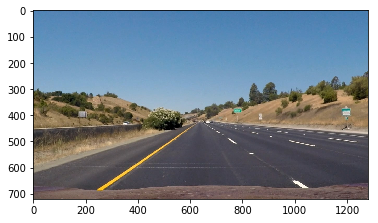

Processed Image with Diags


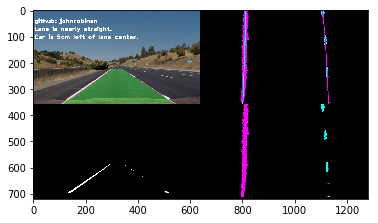

Processed Image


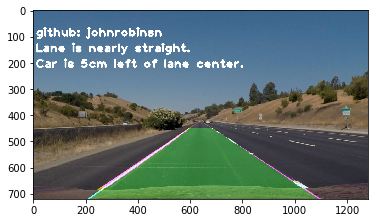

In [18]:
f = "test_images/straight_lines1.jpg" #shadow frome tree
#f = "test_images/test5.jpg"
#f = "other_images/project_video_t41_8s.jpg" #shadow frome tree
#f = "other_images/project_video_t39_8s.jpg"

img = mpimg.imread(f)

plt.imshow(img)
print("Original Image")
plt.show()

out_img = show_lines(img,show_diag=True)
plt.imshow(out_img, cmap="gray")
print("Processed Image with Diags")
plt.show()

out_img = show_lines(img)
plt.imshow(out_img, cmap="gray")
print("Processed Image")
plt.show()





## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [19]:
# This function can be used to get the pipeline processing function in such a way that the lane lines
# will be averaged across the last ten frames when processing video.
# The hardest flag enables some special case processing for the hard_challenge_video
def get_image_processor(show_diag=False, hardest=False):
    clear_line_cache()
    def process_image(image):
        # invoke pipeline but utilize the line cache to average lane line calculations
        # across video frames
        return show_lines(image, use_line_cache=True, show_diag=show_diag, hardest=hardest)
    
    return process_image

## Project Video Processed with Additional Diagnostics
I support a 4 pane view that shows the processing pipeline at different steps of processing for debugging and to gain more insights into when the pipeline is not functioning as expected.

In [20]:
white_diag_output = 'test_videos_output/project_video_diag.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_diag_clip = clip1.fl_image(get_image_processor(show_diag=True)) #NOTE: this function expects color images!!
%time white_diag_clip.write_videofile(white_diag_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_diag.mp4
[MoviePy] Writing video test_videos_output/project_video_diag.mp4


100%|█████████▉| 1260/1261 [01:32<00:00, 14.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_diag.mp4 

CPU times: user 2min 22s, sys: 6.02 s, total: 2min 28s
Wall time: 1min 32s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_diag_output))

## Final Project Video
Here I run the project video through the pipeline for my final results.  It works quite well.

In [22]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(get_image_processor()) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [01:32<00:00, 14.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 2min 20s, sys: 5.7 s, total: 2min 26s
Wall time: 1min 33s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Challenge Video
Pretty good results on the challenge video as well.

In [24]:
challenge_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(get_image_processor()) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [00:32<00:00, 15.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 50.9 s, sys: 2.35 s, total: 53.3 s
Wall time: 32.9 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Challenge Video with Diagnostics

In [26]:
challenge_diag_output = 'test_videos_output/challenge_diag_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(get_image_processor(show_diag=True)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_diag_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_diag_video.mp4
[MoviePy] Writing video test_videos_output/challenge_diag_video.mp4


100%|██████████| 485/485 [00:31<00:00, 15.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_diag_video.mp4 

CPU times: user 51.6 s, sys: 2.49 s, total: 54 s
Wall time: 32.1 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_diag_output))

## Harder Challenge Video
Whereas my pipeline did pretty well on the project video and the challenge video, the harder challenge video demonstrates how fragile my current pipeline performs under much more challenging conditions.

In [28]:
harder_challenge_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(3,7)
white_clip = clip1.fl_image(get_image_processor(hardest=True)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [02:10<00:00,  7.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 2min 44s, sys: 18.1 s, total: 3min 2s
Wall time: 2min 12s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))

In [30]:
harder_challenge_diag_output = 'test_videos_output/harder_challenge_diag_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(3,7)
white_clip = clip1.fl_image(get_image_processor(show_diag=True, hardest=True)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_diag_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_diag_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_diag_video.mp4


100%|█████████▉| 1199/1200 [02:07<00:00,  8.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_diag_video.mp4 

CPU times: user 2min 56s, sys: 11.6 s, total: 3min 8s
Wall time: 2min 8s


In [31]:
"""
# Extract images as needed
clip = VideoFileClip("challenge_video.mp4")
img = clip.get_frame(4.44)
plt.imshow(show_lines(img))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("challenge_video_t4.44s.jpg",img)
"""

'\n# Extract images as needed\nclip = VideoFileClip("challenge_video.mp4")\nimg = clip.get_frame(4.44)\nplt.imshow(show_lines(img))\nimg = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)\ncv2.imwrite("challenge_video_t4.44s.jpg",img)\n'